# Checking the dependence by season of wildfires data


## Data preparation

### import important packages and functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
import psycopg2
from sql_functions import get_engine
from sql_functions import get_sql_config
from sql_functions import get_dataframe
import numpy as np
import scipy.stats as stats
import seaborn as sns

### download data and add information

In [2]:
#download fires_data from our SQL base with columns unique_id, state_name, combined_discovery_date and fire_size
fires_data = get_dataframe('SELECT unique_id, state_name, combined_discovery_date, fire_size FROM capstone_wildfire.fires_data_v1_rdy_to_clean_rows')

In [3]:
#creating a 'month' column in fires_data just to contain the month as integer to better group by month
fires_data['month'] = fires_data['combined_discovery_date'].dt.month

In [4]:
#creating a 'quarter' column to just contain the quarter as int to better group by calendarial quarter
# Define a function to map months to quarters
def get_quarter(month):
    if 1 <= month <= 3:
        return 1
    elif 4 <= month <= 6:
        return 2
    elif 7 <= month <= 9:
        return 3
    else:
        return 4

# Apply the function to create the 'quarter' column
fires_data['quarter'] = fires_data['month'].apply(get_quarter)

# Display the resulting DataFrame
print(fires_data)

         unique_id state_name combined_discovery_date  fire_size  month  \
0          1758431   New York     2009-04-24 19:25:00       1.20      4   
1          1758432   New York     2009-04-25 15:56:00       0.75      4   
2          1758433   New York     2009-09-26 18:03:00       2.75      9   
3          1758434   New York     2009-11-04 15:19:00       0.50     11   
4          1758435   New York     2009-04-12 13:18:00       1.20      4   
...            ...        ...                     ...        ...    ...   
1674433    1758426   New York     2009-04-10 12:15:00       0.75      4   
1674434    1758427   New York     2009-04-16 15:22:00       1.15      4   
1674435    1758428   New York     2009-04-25 10:45:00       0.75      4   
1674436    1758429   New York     2009-04-28 12:05:00       0.95      4   
1674437    1758430   New York     2009-04-16 14:23:00       1.15      4   

         quarter  
0              2  
1              2  
2              3  
3              4  
4   

In [5]:
#creating a 'season' column to contain the meteorological season as object and to be able to group by
# Define a function to map months to seasons
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# Apply the function to create the 'season' column
fires_data['season'] = fires_data['month'].apply(get_season)

# Display the resulting DataFrame
print(fires_data)

         unique_id state_name combined_discovery_date  fire_size  month  \
0          1758431   New York     2009-04-24 19:25:00       1.20      4   
1          1758432   New York     2009-04-25 15:56:00       0.75      4   
2          1758433   New York     2009-09-26 18:03:00       2.75      9   
3          1758434   New York     2009-11-04 15:19:00       0.50     11   
4          1758435   New York     2009-04-12 13:18:00       1.20      4   
...            ...        ...                     ...        ...    ...   
1674433    1758426   New York     2009-04-10 12:15:00       0.75      4   
1674434    1758427   New York     2009-04-16 15:22:00       1.15      4   
1674435    1758428   New York     2009-04-25 10:45:00       0.75      4   
1674436    1758429   New York     2009-04-28 12:05:00       0.95      4   
1674437    1758430   New York     2009-04-16 14:23:00       1.15      4   

         quarter  season  
0              2  spring  
1              2  spring  
2              3  

### create separate dataframes

In [6]:
#Create separate dataframes: filtered_data for our Top 5 states
# Define the list of states to include
selected_states = ['California', 'Oregon', 'Idaho', 'New Mexico', 'Arizona']
# Filter the data to include only the selected states
filtered_data = fires_data[fires_data['state_name'].isin(selected_states)]

In [7]:
#Create separate dataframes to work with separated by our Top 5 states
california_data = fires_data[fires_data['state_name'] == 'California']
arizona_data = fires_data[fires_data['state_name'] == 'Arizona']
idaho_data = fires_data[fires_data['state_name'] == 'Idaho']
new_mexico_data = fires_data[fires_data['state_name'] == 'New Mexico']
oregon_data = fires_data[fires_data['state_name'] == 'Oregon']

## Data visualizations

### on overall data
#### Total Fires per month per state

/var/folders/71/74jym8nn07z_r531l25_2hd00000gn/T/ipykernel_7262/1715362300.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


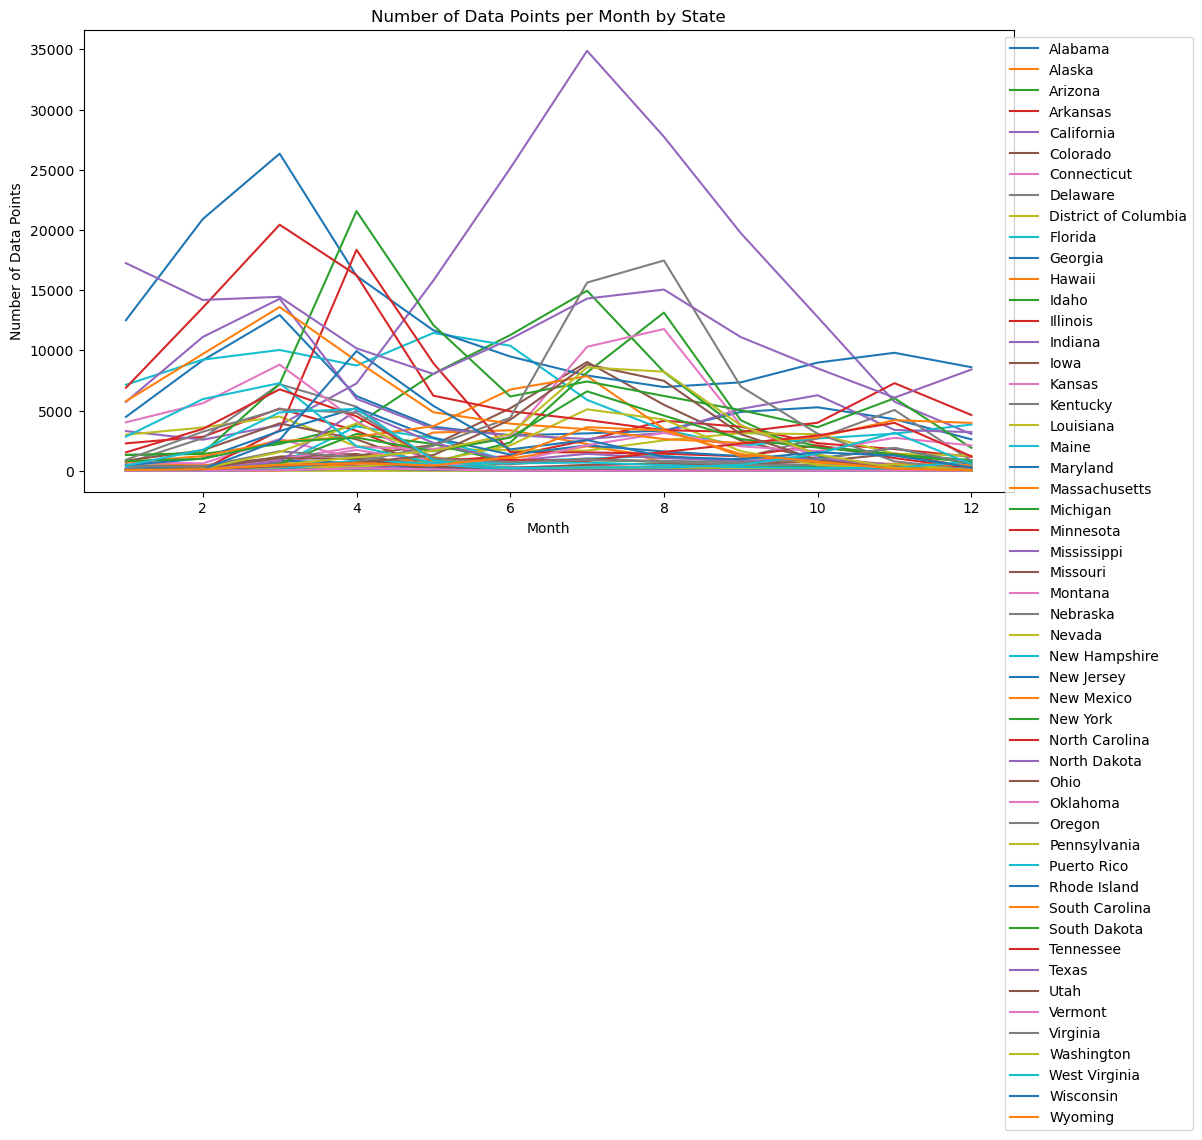

In [8]:
#visualize sum of fires per month by state
#group the data by 'month' and 'state_name' and count the occurrences
all_bymonth_data = fires_data.groupby(['month', 'state_name']).size().unstack().fillna(0)

# create a line chart for each state
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each state and plot the data as a line chart
for state in all_bymonth_data.columns:
    ax.plot(all_bymonth_data.index, all_bymonth_data[state], label=state)

# Set labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Number of Data Points')
ax.set_title('Number of Data Points per Month by State')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.tight_layout()
plt.show()


#### Total fires per month per Top 10 state

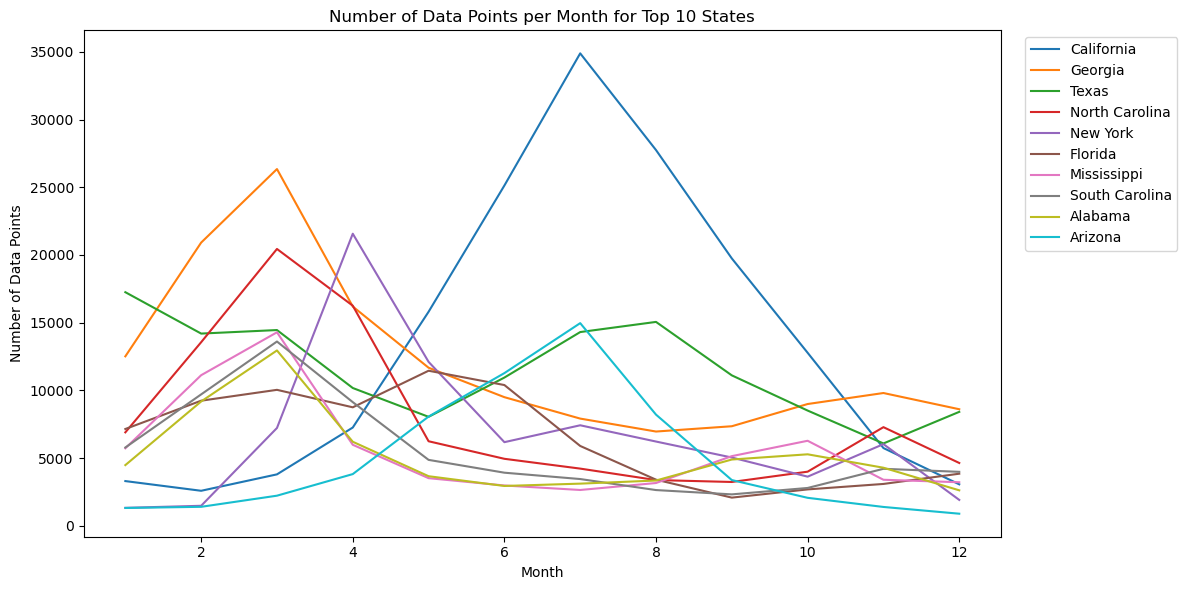

In [9]:
# creating a top 10 states dataframe with the largest of grouped_data
top_10_states = all_bymonth_data.sum().nlargest(10).index

# Filter the data to include only the top 10 states
top_10_data = all_bymonth_data[top_10_states]

# Now, you can create a line chart for each of the top 10 states
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each state and plot the data as a line chart
for state in top_10_data.columns:
    ax.plot(top_10_data.index, top_10_data[state], label=state)

# Set labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Number of Data Points')
ax.set_title('Number of Data Points per Month for Top 10 States')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.tight_layout()
plt.show()

### on our Top5 states
#### Total fires per month per Top5 state

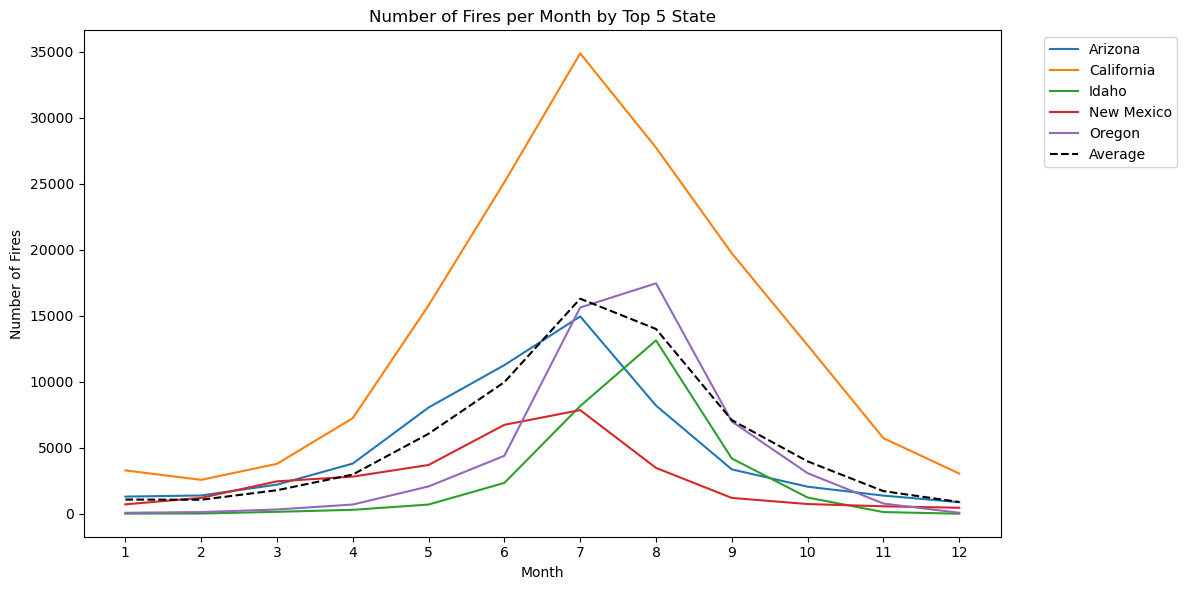

In [10]:
# Group the filtered data by 'month' and 'state_name' and count the occurrences
bymonth_data = filtered_data.groupby(['month', 'state_name']).size().unstack().fillna(0)

# Calculate the average number of fires for each month
average_line = bymonth_data.mean(axis=1)

# Create a line chart for each state
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each state and plot the data as a line chart
for state in bymonth_data.columns:
    ax.plot(bymonth_data.index, bymonth_data[state], label=state)

# Plot the average line
ax.plot(bymonth_data.index, average_line, label='Average', linestyle='--', color='black')

# Set labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Number of Fires')
ax.set_title('Number of Fires per Month by Top 5 State')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Set the x-axis ticks to be the unique values from the 'month' column
ax.set_xticks(bymonth_data.index)

# Show the plot
plt.tight_layout()
plt.show()

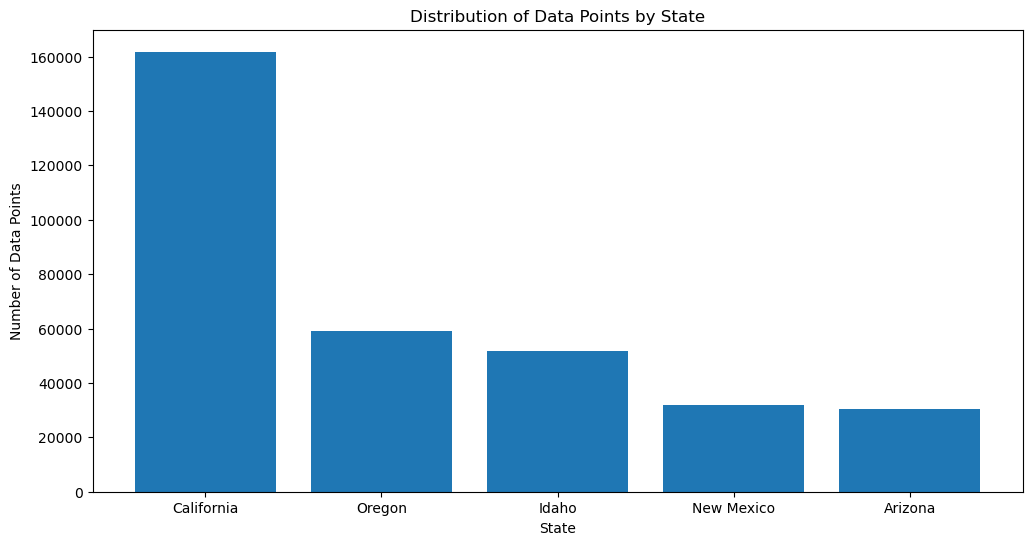

In [11]:
# Create a bar plot to visualize the distribution of data points by state
plt.figure(figsize=(12, 6))
plt.bar(selected_states, filtered_data['state_name'].value_counts())
plt.xlabel('State')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Data Points by State')
plt.show()

#### Total fires per quarter by Top 5 state

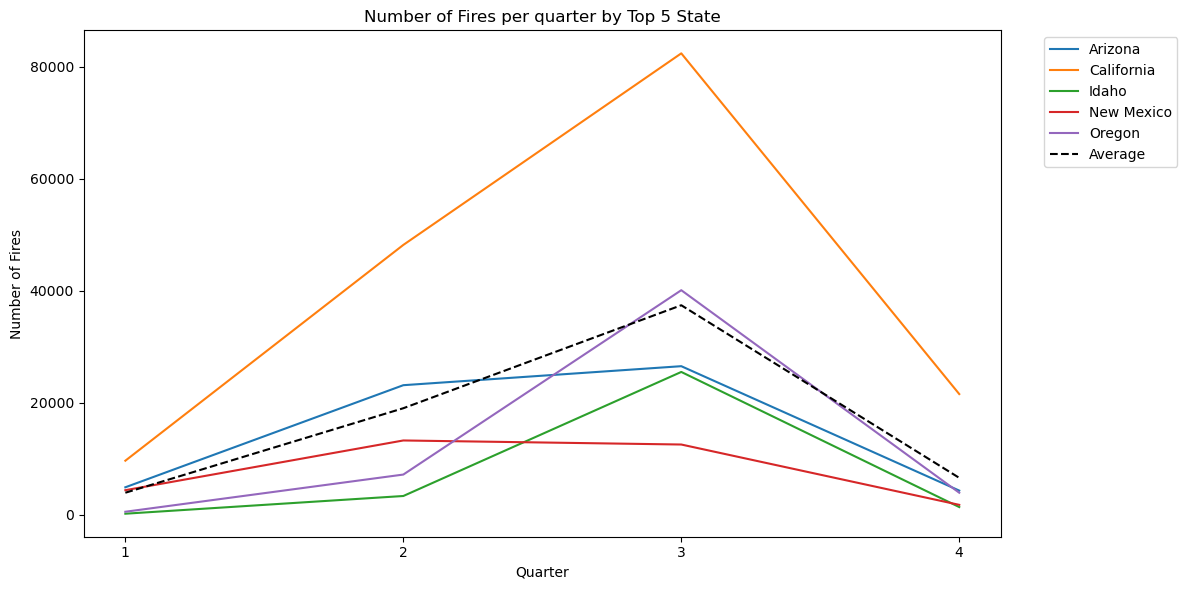

In [12]:
# Group the filtered data by 'month' and 'state_name' and count the occurrences
byquarter_data = filtered_data.groupby(['quarter', 'state_name']).size().unstack().fillna(0)

# Calculate the average number of fires for each month
average_line = byquarter_data.mean(axis=1)

# Create a line chart for each state
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each state and plot the data as a line chart
for state in byquarter_data.columns:
    ax.plot(byquarter_data.index, byquarter_data[state], label=state)

# Plot the average line
ax.plot(byquarter_data.index, average_line, label='Average', linestyle='--', color='black')

# Set labels and title
ax.set_xlabel('Quarter')
ax.set_ylabel('Number of Fires')
ax.set_title('Number of Fires per quarter by Top 5 State')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Set the x-axis ticks to be the unique values from the 'month' column
ax.set_xticks(byquarter_data.index)

# Show the plot
plt.tight_layout()
plt.show()

#### Total fires in Top 5 states by season

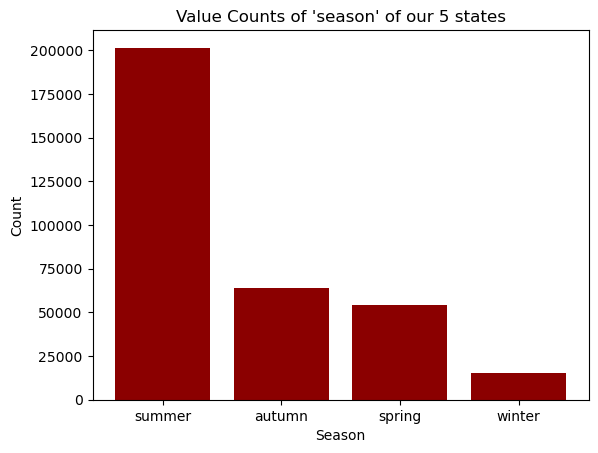

In [13]:
#visualization of distribution of 'season' for all 5 states
season_counts = filtered_data['season'].value_counts()

# Create a bar plot using Matplotlib
plt.bar(season_counts.index, season_counts.values, color='darkred')

# Add labels and a title
plt.xlabel('Season')
plt.ylabel('Count')
plt.title("Value Counts of 'season' of our 5 states")

# Show the plot
plt.show()

#### Total fires per season per Top 5 state

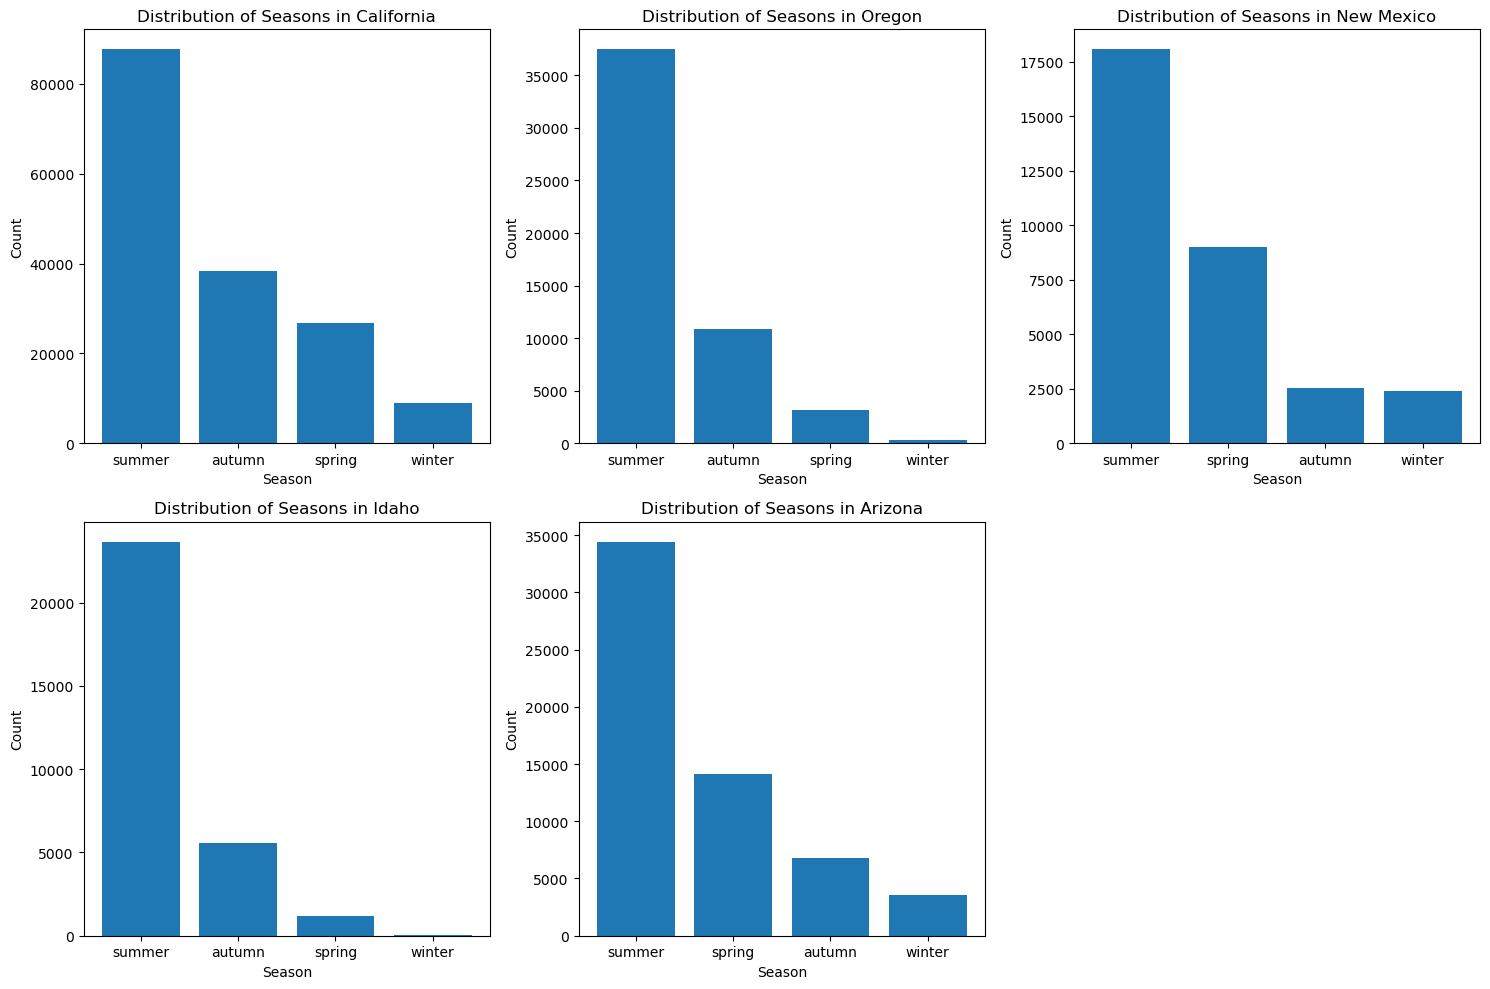

In [14]:
#creating a list of datasets and a list of dataframe-names to add them to the single titles in vis
data_frames = [california_data, oregon_data, new_mexico_data, idaho_data, arizona_data]
data_frame_names = ['California', 'Oregon', 'New Mexico', 'Idaho', 'Arizona']

# Calculate the number of rows and columns based on the number of DataFrames
num_data_frames = len(data_frames)
num_cols = 3
num_rows = (num_data_frames + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create a subplot grid based on the calculated number of rows and columns
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

# Iterate through the datasets and create a bar plot for each one
for i, data in enumerate(data_frames):
    row = i // num_cols
    col = i % num_cols
    season_counts = data['season'].value_counts()
    
    # Create a bar plot for the current dataset
    axes[row, col].bar(season_counts.index, season_counts.values)
    axes[row, col].set_title(f'Distribution of Seasons in {data_frame_names[i]}')
    axes[row, col].set_xlabel('Season')
    axes[row, col].set_ylabel('Count')

# Remove any empty subplots
for i in range(num_data_frames, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### Descriptive statistics on Top 5 states

#### Descriptives on overall monthly distribution by state

In [15]:
state_counts_by_month = filtered_data.groupby(['month', 'state_name']).size().unstack(fill_value=0)
print(state_counts_by_month)

state_name  Arizona  California  Idaho  New Mexico  Oregon
month                                                     
1              1309        3295     20         722      83
2              1395        2579     29        1216     138
3              2217        3792    156        2465     333
4              3812        7251    309        2824     709
5              8060       15801    708        3706    2080
6             11271       25127   2348        6747    4403
7             14961       34888   8168        7862   15633
8              8204       27745  13143        3483   17466
9              3370       19740   4197        1209    6999
10             2059       12772   1239         746    3083
11             1385        5735    138         575     782
12              886        3055     14         464      85


#### Descriptives on quarterly distribution

In [16]:
print('Descriptive data on quarterly distribution on all Top 5 states')
print(filtered_data['quarter'].describe())

Descriptive data on quarterly distribution on all Top 5 states
count    334991.000000
mean          2.696601
std           0.725524
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           4.000000
Name: quarter, dtype: float64


In [17]:
print('Descriptive data on quarterly distribution for California')
print(california_data['quarter'].describe())

Descriptive data on quarterly distribution for California
count    161780.000000
mean          2.715978
std           0.767732
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           4.000000
Name: quarter, dtype: float64


In [18]:
print('Descriptive data on quarterly distribution for Oregon')
print(oregon_data['quarter'].describe())

Descriptive data on quarterly distribution for Oregon
count    51794.000000
mean         2.916013
std          0.500857
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: quarter, dtype: float64


In [19]:
print('Descriptive data on quarterly distribution for New Mexico')
print(new_mexico_data['quarter'].describe())

Descriptive data on quarterly distribution for New Mexico
count    32019.000000
mean         2.366064
std          0.786512
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: quarter, dtype: float64


In [20]:
print('Descriptive data on quarterly distribution for Idaho')
print(idaho_data['quarter'].describe())

Descriptive data on quarterly distribution for Idaho
count    30469.000000
mean         2.921757
std          0.420582
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: quarter, dtype: float64


In [21]:
print('Descriptive data on quarterly distribution for Arizona')
print(arizona_data['quarter'].describe())

Descriptive data on quarterly distribution for Arizona
count    58929.000000
mean         2.513737
std          0.750861
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: quarter, dtype: float64


#### Descriptives on monthly data

In [22]:
print('Descriptive data on monthly distribution on all Top 5 states')
print(filtered_data['month'].describe())

Descriptive data on monthly distribution on all Top 5 states
count    334991.000000
mean          7.021541
std           2.058660
min           1.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          12.000000
Name: month, dtype: float64


In [23]:
print('Descriptive data on monthly distribution for California')
print(california_data['month'].describe())

Descriptive data on monthly distribution for California
count    161780.000000
mean          7.107807
std           2.203165
min           1.000000
25%           6.000000
50%           7.000000
75%           9.000000
max          12.000000
Name: month, dtype: float64


In [24]:
print('Descriptive data on monthly distribution for Oregon')
print(oregon_data['month'].describe())

Descriptive data on monthly distribution for Oregon
count    51794.000000
mean         7.599606
std          1.390176
min          1.000000
25%          7.000000
50%          8.000000
75%          8.000000
max         12.000000
Name: month, dtype: float64


In [25]:
print('Descriptive data on monthly distribution for New Mexico')
print(new_mexico_data['month'].describe())

Descriptive data on monthly distribution for New Mexico
count    32019.000000
mean         6.058559
std          2.166425
min          1.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         12.000000
Name: month, dtype: float64


In [26]:
print('Descriptive data on monthly distribution for Idaho')
print(idaho_data['month'].describe())

Descriptive data on monthly distribution for Idaho
count    30469.000000
mean         7.666120
std          1.174407
min          1.000000
25%          7.000000
50%          8.000000
75%          8.000000
max         12.000000
Name: month, dtype: float64


In [27]:
print('Descriptive data on monthly distribution for Arizona')
print(arizona_data['month'].describe())

Descriptive data on monthly distribution for Arizona
count    58929.000000
mean         6.466595
std          2.112794
min          1.000000
25%          5.000000
50%          7.000000
75%          8.000000
max         12.000000
Name: month, dtype: float64


#### saving monthly counts in df

In [28]:
#saving the result of value_counts in a variable
value_counts_result = filtered_data['month'].value_counts()

# Convert the result to a DataFrame
filtered_monthly_count = pd.DataFrame({'month': value_counts_result.index, 'count': value_counts_result.values})

In [29]:
#saving the result of value_counts in a variable
value_counts_result = california_data['month'].value_counts()

# Convert the result to a DataFrame
california_monthly_count = pd.DataFrame({'month': value_counts_result.index, 'count': value_counts_result.values})

In [30]:
#saving the result of value_counts in a variable
value_counts_result = oregon_data['month'].value_counts()

# Convert the result to a DataFrame
oregon_monthly_count = pd.DataFrame({'month': value_counts_result.index, 'count': value_counts_result.values})

In [31]:
#saving the result of value_counts in a variable
value_counts_result = new_mexico_data['month'].value_counts()

# Convert the result to a DataFrame
new_mexico_monthly_count = pd.DataFrame({'month': value_counts_result.index, 'count': value_counts_result.values})

In [32]:
#saving the result of value_counts in a variable
value_counts_result = idaho_data['month'].value_counts()

# Convert the result to a DataFrame
idaho_monthly_count = pd.DataFrame({'month': value_counts_result.index, 'count': value_counts_result.values})

In [33]:
#saving the result of value_counts in a variable
value_counts_result = arizona_data['month'].value_counts()

# Convert the result to a DataFrame
arizona_monthly_count = pd.DataFrame({'month': value_counts_result.index, 'count': value_counts_result.values})

#### calculating correlation on months

In [34]:
#calculating correlation of number of fires on months for all Top 5 states
correlation_coefficient = np.corrcoef(filtered_monthly_count['month'], filtered_monthly_count['count'])[0, 1]
print(f"Top 5 states Pearson Correlation Coefficient: {correlation_coefficient}")

Top 5 states Pearson Correlation Coefficient: 0.16626181970563006


In [35]:
#calculating correlation for California on months
correlation_coefficient = np.corrcoef(california_monthly_count['month'], california_monthly_count['count'])[0, 1]
print(f"California Pearson Correlation Coefficient: {correlation_coefficient}")

California Pearson Correlation Coefficient: 0.22244969827957048


In [36]:
#calculating correlation for Oregon on months
correlation_coefficient = np.corrcoef(oregon_monthly_count['month'], oregon_monthly_count['count'])[0, 1]
print(f"Oregon Pearson Correlation Coefficient: {correlation_coefficient}")

Oregon Pearson Correlation Coefficient: 0.23539361911731677


In [37]:
#calculating correlation for New Mexico on months
correlation_coefficient = np.corrcoef(new_mexico_monthly_count['month'], new_mexico_monthly_count['count'])[0, 1]
print(f"New Mexico Pearson Correlation Coefficient: {correlation_coefficient}")

New Mexico Pearson Correlation Coefficient: -0.14507613122395197


In [38]:
#calculating correlation for Idaho on months
correlation_coefficient = np.corrcoef(idaho_monthly_count['month'], idaho_monthly_count['count'])[0, 1]
print(f"Idaho Pearson Correlation Coefficient: {correlation_coefficient}")

Idaho Pearson Correlation Coefficient: 0.21704671284710134


In [39]:
#calculating correlation for Arizona on months
correlation_coefficient = np.corrcoef(arizona_monthly_count['month'], arizona_monthly_count['count'])[0, 1]
print(f"Arizona Pearson Correlation Coefficient: {correlation_coefficient}")

Arizona Pearson Correlation Coefficient: -0.010734683546310466


### Heatmap on Top 5 states

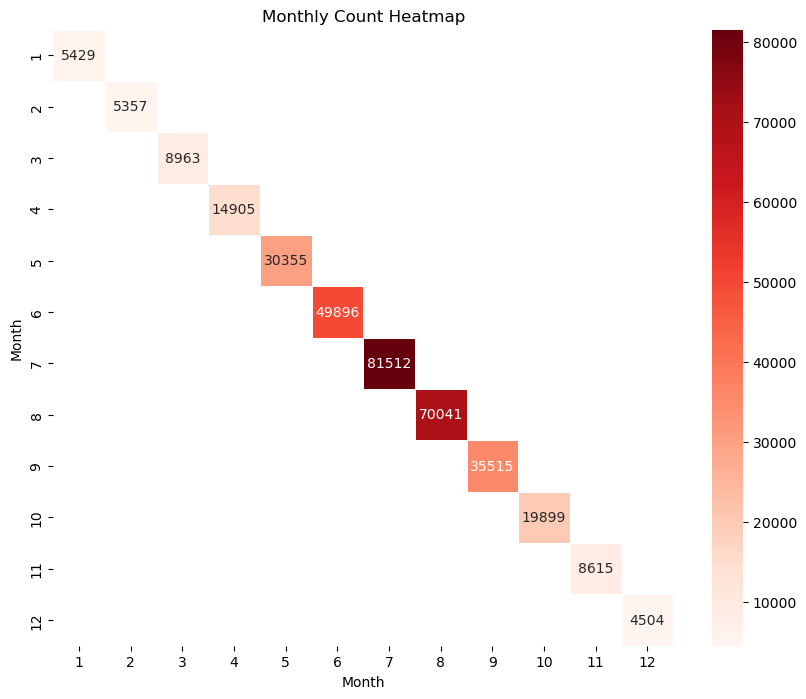

In [40]:
# Assuming 'df' is your DataFrame containing 'filtered_monthly_count' data
pivot_table = filtered_monthly_count.pivot_table(index='month', columns='month', values='count')

plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(pivot_table, annot=True, cmap="Reds", fmt='g', linewidths=.5)
plt.title('Monthly Count Heatmap')
plt.xlabel('Month')
plt.ylabel('Month')
plt.show()


In [41]:
filtered_monthly_count

,month,count
0,7,81512
1,8,70041
2,6,49896
3,9,35515
4,5,30355
5,10,19899
6,4,14905
7,3,8963
8,11,8615
9,1,5429


/var/folders/71/74jym8nn07z_r531l25_2hd00000gn/T/ipykernel_7262/3292720366.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Anzahl')


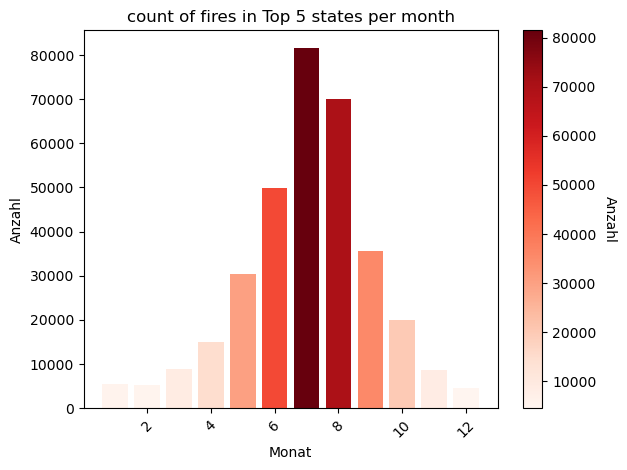

In [42]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Erstellen Sie eine Farbpalette von hellrot (geringe Anzahl) bis dunkelrot (hohe Anzahl).
# Hier verwenden wir eine lineare Interpolation zwischen Weiß und Rot.
min_count = filtered_monthly_count['count'].min()
max_count = filtered_monthly_count['count'].max()
norm = mcolors.Normalize(vmin=min_count, vmax=max_count)
cmap = plt.get_cmap('Reds')

# Erstellen Sie das Balkendiagramm mit den 'count'-Werten und der Farbskala.
plt.bar(filtered_monthly_count['month'], filtered_monthly_count['count'], color=cmap(norm(filtered_monthly_count['count'])))
plt.xticks(rotation=45)  # Optional: Rotieren Sie die x-Achsenbeschriftungen, wenn erforderlich.

# Fügen Sie eine Farbskala hinzu, um die Zuordnung zwischen Balkenhöhe und Farbe zu erklären.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Leere Array-Zuordnung erforderlich.
cbar = plt.colorbar(sm, label='Anzahl')
cbar.set_label('Anzahl', rotation=270, labelpad=15)

# Beschriftungen und Titel hinzufügen
plt.xlabel('Monat')
plt.ylabel('Anzahl')
plt.title('count of fires in Top 5 states per month')

# Zeigen Sie das Diagramm an oder speichern Sie es in eine Datei.
plt.tight_layout()
plt.show()

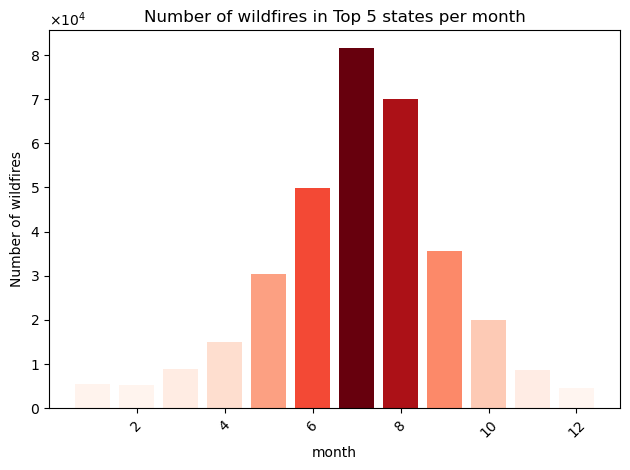

In [50]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter

# Erstellen Sie eine Farbpalette von hellrot (geringe Anzahl) bis dunkelrot (hohe Anzahl).
# Hier verwenden wir eine lineare Interpolation zwischen Weiß und Rot.
min_count = filtered_monthly_count['count'].min()
max_count = filtered_monthly_count['count'].max()
norm = mcolors.Normalize(vmin=min_count, vmax=max_count)
cmap = plt.get_cmap('Reds')

# Erstellen Sie das Balkendiagramm mit den 'count'-Werten und der Farbskala.
plt.bar(filtered_monthly_count['month'], filtered_monthly_count['count'], color=cmap(norm(filtered_monthly_count['count'])))
plt.xticks(rotation=45)

# Fügen Sie eine Farbskala hinzu, um die Zuordnung zwischen Balkenhöhe und Farbe zu erklären.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Leere Array-Zuordnung erforderlich.
#cbar = plt.colorbar(sm, label='Anzahl')
#cbar.set_label('Anzahl', rotation=270, labelpad=15)

# Beschriftungen und Titel hinzufügen
plt.xlabel('month')
plt.ylabel('Number of wildfires')
plt.title('Number of wildfires in Top 5 states per month')

# Format the y-axis to display in scientific notation 
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# Zeigen Sie das Diagramm an oder speichern Sie es in eine Datei.
plt.tight_layout()
plt.show()



### California visualisations

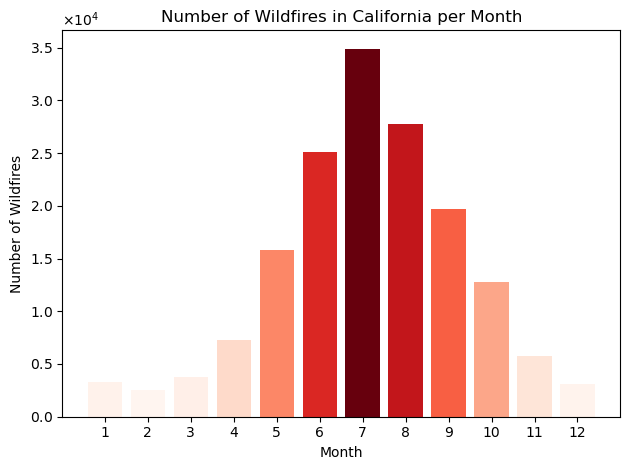

In [58]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter

# Erstellen Sie eine Farbpalette von hellrot (geringe Anzahl) bis dunkelrot (hohe Anzahl).
# Hier verwenden wir eine lineare Interpolation zwischen Weiß und Rot.
min_count = california_monthly_count['count'].min()
max_count = california_monthly_count['count'].max()
norm = mcolors.Normalize(vmin=min_count, vmax=max_count)
cmap = plt.get_cmap('Reds')

# Erstellen Sie das Balkendiagramm mit den 'count'-Werten und der Farbskala.
plt.bar(california_monthly_count['month'], california_monthly_count['count'], color=cmap(norm(california_monthly_count['count'])))
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
plt.xticks(x)

# Fügen Sie eine Farbskala hinzu, um die Zuordnung zwischen Balkenhöhe und Farbe zu erklären.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Leere Array-Zuordnung erforderlich.
#cbar = plt.colorbar(sm, label='Anzahl')
#cbar.set_label('Anzahl', rotation=270, labelpad=15)

# Beschriftungen und Titel hinzufügen
plt.xlabel('Month')
plt.ylabel('Number of Wildfires')
plt.title('Number of Wildfires in California per Month')

# Format the y-axis to display in scientific notation 
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# Zeigen Sie das Diagramm an oder speichern Sie es in eine Datei.
plt.tight_layout()
plt.show()


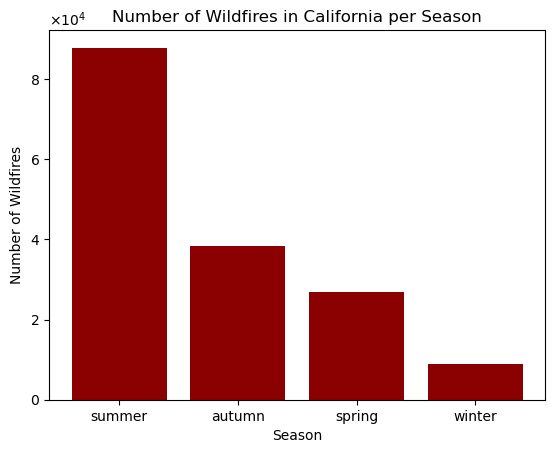

In [61]:
#visualization of distribution of 'season' for all 5 states
season_counts = california_data['season'].value_counts()

# Create a bar plot using Matplotlib
plt.bar(season_counts.index, season_counts.values, color='darkred')

# Add labels and a title
plt.xlabel('Season')
plt.ylabel('Number of Wildfires')
plt.title("Number of Wildfires in California per Season")

# Format the y-axis to display in scientific notation 
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# Show the plot
plt.show()

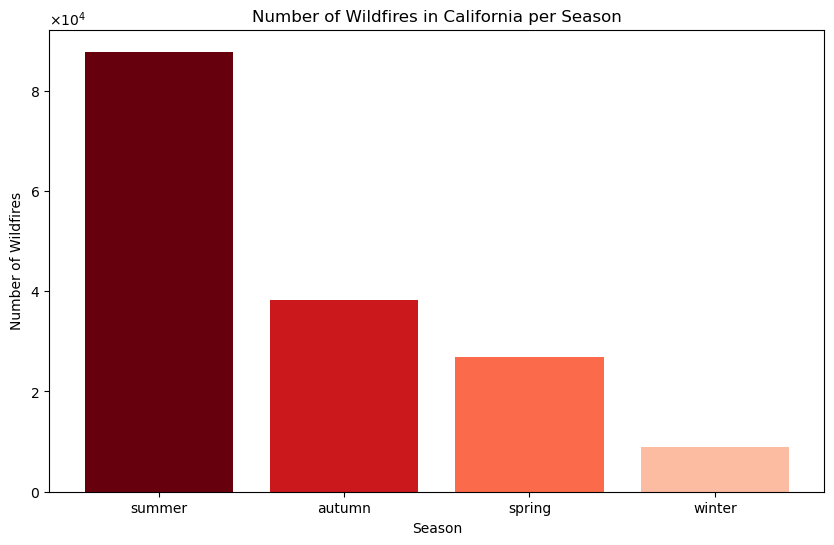

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'california_data' with a 'season' column
# You can create a bar chart of the value counts
season_counts = california_data['season'].value_counts()

# Sorting the counts in descending order
season_counts = season_counts.sort_values(ascending=False)

# Define a color map ranging from light to dark red
colors = plt.cm.Reds_r(range(0, 256, int(256 / len(season_counts))))

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(season_counts.index, season_counts, color=colors)

# Adding labels and title
plt.xlabel('Season')
plt.ylabel('Number of Wildfires')
plt.title('Number of Wildfires in California per Season')

# Format the y-axis to display in scientific notation 
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0))


# Show the chart
plt.xticks(rotation=0)
plt.show()


## conclusion

As the month / season / quarter is a categorical measure, calculating a correlation is not possible. Even if the correlation is close to zero, we see in the visualizations that sometimes over the half of the fires are happening in summer months, especially in June and July. Further analysis and correlation calculation especially with concrete temperature data is needed.